In [2]:
import json 
import numpy as np
import os
import os.path as osp
import json
from argparse import ArgumentParser
from glob import glob
import matplotlib.pyplot as plt

import torch
import cv2
from torch import cuda
from model import EAST
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations.geometric.resize import LongestMaxSize
import lanms
from dataset import get_rotate_mat

from detect import is_valid_poly, restore_polys

In [3]:
 model = EAST(pretrained=False).cuda()

# Get paths to checkpoint files
ckpt_fpath = osp.join("trained_models", 'epoch_40.pth')
model.load_state_dict(torch.load(ckpt_fpath, map_location = "cpu"))
model.eval()
print('Inference in progress')

Inference in progress


In [5]:
with open("/opt/ml/input/data/ICDAR19/ufo/train.json", "rb") as f: 
    full_json = json.load(f)
    
with open("/opt/ml/input/data/camper/ufo/train.json", "rb") as f: 
    camper_json = json.load(f)

In [6]:
def check_size(json_file):
    cnt = 0
    length = 0
    for img_file, img_info in json_file["images"].items():
        length+=1
        height = img_info["img_h"]
        width = img_info["img_w"]
        maximum = max(height , width)
        minimum = min(height, width)
        required_maximum = int(2048 * minimum / 2044) 
        if maximum < required_maximum:
            cnt+=1
    print("Total length:", length, "Would go to black hall:", cnt)
    return cnt, length

In [7]:
check_size(full_json)

Total length: 10000 Would go to black hall: 336


(336, 10000)

In [8]:
check_size(camper_json)

Total length: 974 Would go to black hall: 41


(41, 974)

# Warning

- detect를 custom하게 바꿔준다.

In [9]:
def get_bboxes(score, geo, score_thresh=0.9, nms_thresh=0.2):
    '''get boxes from feature map
    Input:
        score       : score map from model <numpy.ndarray, (1,row,col)>
        geo         : geo map from model <numpy.ndarray, (5,row,col)>
        score_thresh: threshold to segment score map
        nms_thresh  : threshold in nms
    Output:
        boxes       : final polys <numpy.ndarray, (n,9)>
    '''
    score = score[0, :, :]
    
    xy_text = np.argwhere(score > score_thresh) # n x 2, format is [r, c]
    if xy_text.size == 0:
        return None

    xy_text = xy_text[np.argsort(xy_text[:, 0])]
    valid_pos = xy_text[:, ::-1].copy()  # n x 2, [x, y]
    valid_geo = geo[:, xy_text[:, 0], xy_text[:, 1]]  # 5 x n
    polys_restored, index = restore_polys(valid_pos, valid_geo, score.shape)
    if polys_restored.size == 0:
        return None

    boxes = np.zeros((polys_restored.shape[0], 9), dtype=np.float32)
    boxes[:, :8] = polys_restored
    boxes[:, 8] = score[xy_text[index, 0], xy_text[index, 1]]
    boxes = lanms.merge_quadrangle_n9(boxes.astype('float32'), nms_thresh)
    return boxes
def detect(model, images, input_size):
    prep_fn = A.Compose([
        LongestMaxSize(input_size), A.PadIfNeeded(min_height=input_size, min_width=input_size,
                                                  position=A.PadIfNeeded.PositionType.TOP_LEFT),
        A.Normalize(), ToTensorV2()])
    device = list(model.parameters())[0].device

    batch, orig_sizes = [], []
    for image in images:
        orig_sizes.append(image.shape[:2])
        batch.append(prep_fn(image=image)['image'])
    batch = torch.stack(batch, dim=0).to(device)

    with torch.no_grad():
        score_maps, geo_maps = model(batch)
    score_maps, geo_maps = score_maps.cpu().numpy(), geo_maps.cpu().numpy()

    by_sample_bboxes = []
    for score_map, geo_map, orig_size in zip(score_maps, geo_maps, orig_sizes):
        map_margin = int(abs(orig_size[0] - orig_size[1]) * 0.25 * input_size / max(orig_size))
        if orig_size[0] > orig_size[1]:
            score_map, geo_map = score_map[:, :, :-map_margin], geo_map[:, :, :-map_margin]
        elif orig_size[0] < orig_size[1]:
            score_map, geo_map = score_map[:, :-map_margin, :], geo_map[:, :-map_margin, :]

        bboxes = get_bboxes(score_map, geo_map)
        if bboxes is None:
            bboxes = np.zeros((0, 4, 2), dtype=np.float32)
        else:
            bboxes = bboxes[:, :8].reshape(-1, 4, 2)
            bboxes *= max(orig_size) / input_size

        by_sample_bboxes.append(bboxes)

    return by_sample_bboxes


### Find strange sample 

#### 검증하고 싶은 가설:

- [ ] 세로 데이터셋을 잘 탐지하는가?

- [ ] 이상한 데이터셋을 잘 탐지하는가?

- [ ] 빼곡한 데이터셋을 잘 탐지하는가?




In [10]:
def find_vertical_data(json_file):
    vertical_images = []
    strange_images = []
    word_cnt_images = []
    for img_file, img_info in json_file["images"].items():
        vertical_word_cnt = 0
        strange_word_cnt = 0
        word_cnt = 0
        word_info = img_info["words"]
        for word, word_value in word_info.items():
            word_cnt +=1
            if word_value["orientation"] == "Horizontal" : continue
            elif word_value["orientation"] == "Vertical" : 
                vertical_word_cnt +=1 
            else:
                strange_word_cnt +=1
        vertical_images.append((img_file , vertical_word_cnt))
        strange_images.append((img_file , strange_word_cnt))
        word_cnt_images.append((img_file, word_cnt))
        vertical_images = sorted(vertical_images, key = lambda x: -x[1])
        strange_images = sorted(strange_images, key = lambda x: -x[1])
        word_cnt_images = sorted(word_cnt_images, key = lambda x: -x[1])
    return vertical_images, strange_images, word_cnt_images

In [11]:
verticals, stranges, many_datas = find_vertical_data(camper_json)

In [12]:
VERTICAL = [fname for fname, _ in verticals[:1]]
STRANGE = [fname for fname, _ in stranges[:1]]
TMI = [fname for fname, _ in many_datas[:1]]

In [13]:
VERTICAL

['20210913_005506.jpg']

In [15]:
DATA_PATH = "/opt/ml/input/data/camper/images"

In [44]:
def plot_prediction(samples, source_val_json, augmentation = False):
    for image_path in samples:
        
        #LIST가 중요함.
        img = cv2.imread(osp.join(DATA_PATH, image_path))[:, :, ::-1]
        W, H, _ = img.shape
        
        if augmentation:
            img = np.rot90(img)
        img = [img]
        
        fig, ax = plt.subplots(1,1)
        model.eval()
        prediction = detect(model, img, 1024)[0]

        ground_truth = source_val_json["images"][image_path]["words"]
        
        for idx, word in enumerate(prediction):
            word =word[::-1]
            word = np.append(word, word[0]).reshape(-1,2)
            for prev_pos, next_pos in zip(word[:-1], word[1:]):
                ax.plot( [prev_pos[0], next_pos[0]], [prev_pos[1], next_pos[1]]
                        ,color='b', linestyle='-', linewidth=1.5)
        
        for word_key, word_val in ground_truth.items():
            word = np.array(word_val["points"])
            
#             print("word:", word)
            if augmentation:
                rotate_mtx = [[0, -1], [1,0]]
                center = np.sum(word, axis = 0) / len(word)
                
                new_word = []
                for subword in word:
                    subword = rotate_mtx @ subword + np.array([H,0])
                    new_word.append(subword)
                word = np.array(new_word)
#                 print("word:", word)
            word = word[::-1]
            word = np.append(word, word[0]).reshape(-1,2)
            for prev_pos, next_pos in zip(word[:-1], word[1:]):
                ax.plot( [prev_pos[0], next_pos[0]], [prev_pos[1], next_pos[1]]
                        ,color='r', linestyle='-', linewidth=1.5)
        ax.axis("off")
        ax.imshow(img[0])

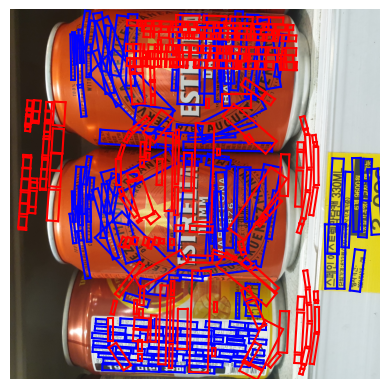

In [45]:
plot_prediction(VERTICAL, camper_json, True)

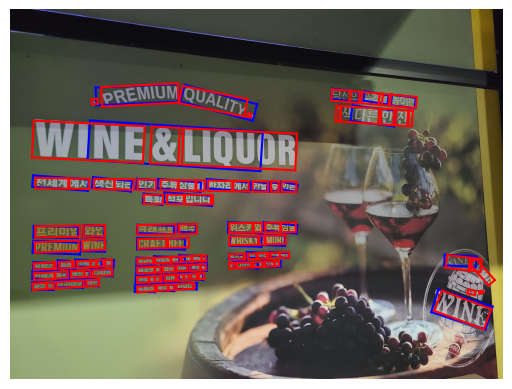

In [18]:
plot_prediction(VERTICAL, camper_json)

In [54]:
VERTICAL = ['1632652513869-8.jpg']

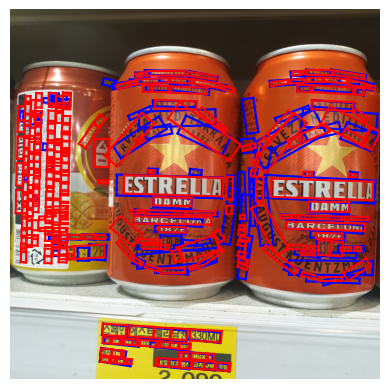

In [55]:
plot_prediction(VERTICAL, camper_json)

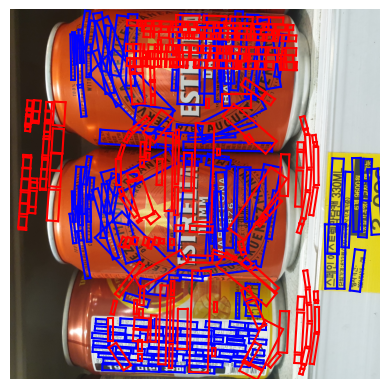

In [56]:
plot_prediction(VERTICAL, camper_json, True)

In [22]:
example

array([[ 5, 10]])

In [23]:
new = rotate_mtx @ tmp

NameError: name 'rotate_mtx' is not defined

In [370]:
new

array([-10,   5])

In [362]:
new.flatten()

array([10,  5])

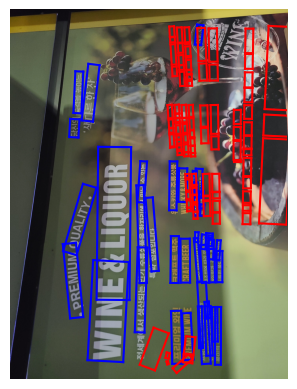

In [24]:
plot_prediction(VERTICAL, camper_json, augmentation = True)

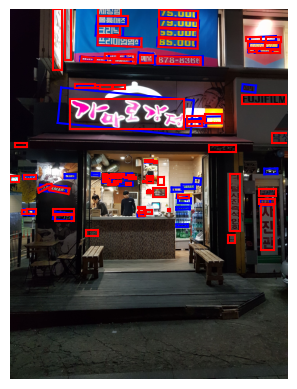

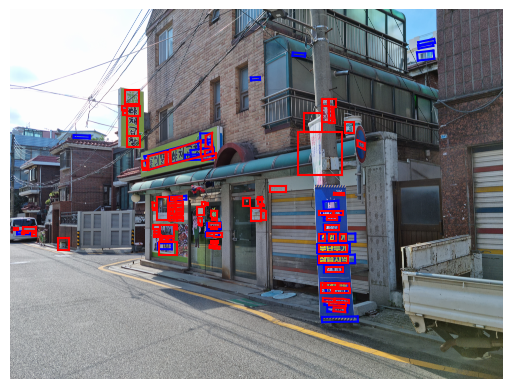

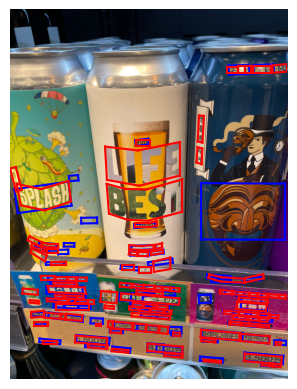

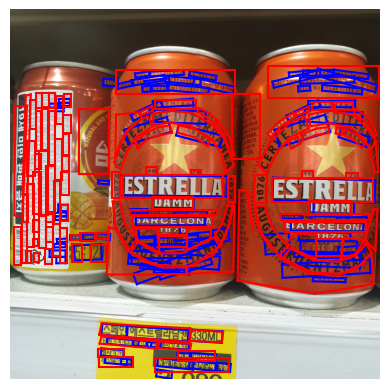

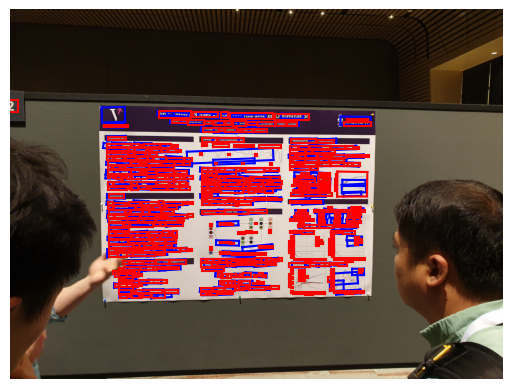

In [319]:
plot_prediction(STRANGE, camper_json)

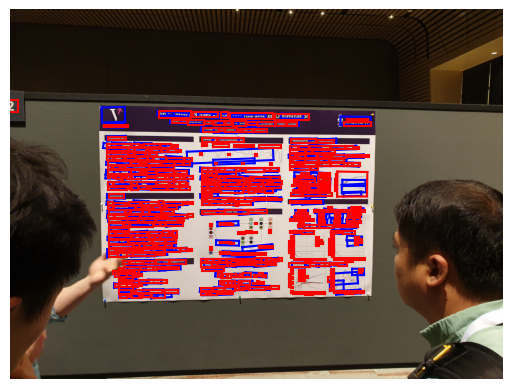

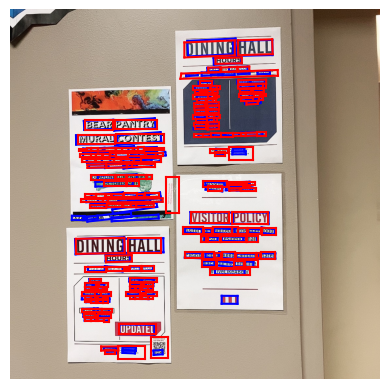

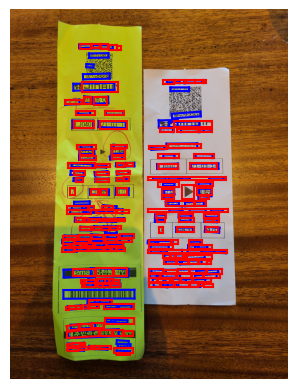

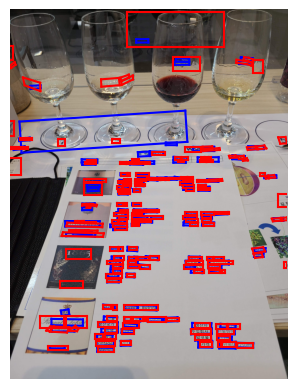

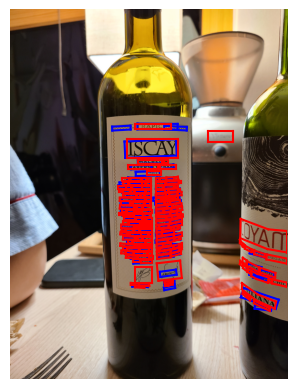

In [320]:
plot_prediction(TMI, camper_json)

## 가설 확인 : 세로 사진을 가로로 돌리면 탐지를 잘할까?

In [321]:
img = cv2.imread(osp.join(DATA_PATH, '1632652513869-8.jpg'))[:, :, ::-1]

In [322]:
rotation= np.rot90(img)

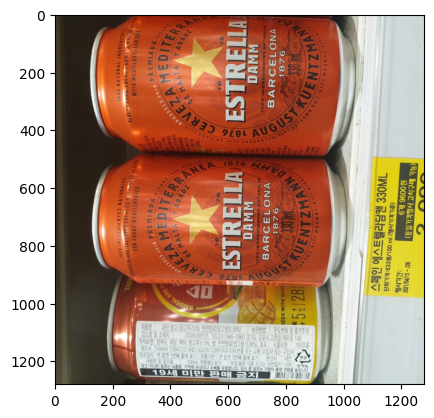

In [323]:
plt.imshow(rotation)

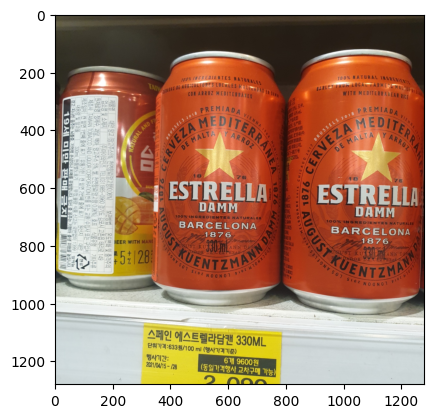

In [301]:
plt.imshow(img)

image shape: (1280, 1280, 3)
image shape until 2: (1280, 1280)
changed image shape: torch.Size([3, 1024, 1024])
batch shape??: torch.Size([1, 3, 1024, 1024]) element shape: torch.Size([3, 1024, 1024])
score_maps.shape: torch.Size([1, 1, 256, 256]) type: <class 'torch.Tensor'>
max value of score maps: tensor(1., device='cuda:0')
geo_maps.shape: torch.Size([1, 5, 256, 256]) type: <class 'torch.Tensor'>
length of score_maps and geo_maps: 1 1
map_margin: 0
score map size: (1, 256, 256)
geo map size: (5, 256, 256)
length: 256
length of score map: 256
ele: [ 15.98275039 333.11535675] type: <class 'numpy.ndarray'>


ValueError: Axes must be different.

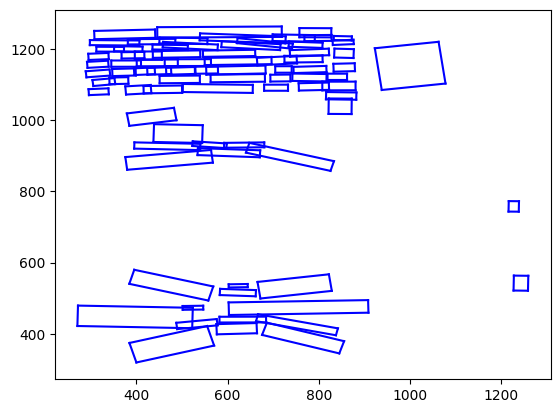

In [302]:
plot_prediction(VERTICAL, camper_json, True)

In [ ]:
ufo_result = dict(images=dict())
split_result = do_inference(model, ckpt_fpath, DATA_PATH
                            , 1024,
                                20)

In [ ]:
split_result["images"]["img_1001.jpg"]